In [ ]:
#0.73164

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt

from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [16]:
# 1. Load & preprocess train data
train = pd.read_csv("data/train.csv")
train = train[['Canonical_Smiles', 'Inhibition']]
train['mol'] = train['Canonical_Smiles'].apply(Chem.MolFromSmiles)
train = train[train['mol'].notnull()].reset_index(drop=True)

In [17]:
# 2. Calculate Mordred descriptors
calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(train['mol'])
desc = desc.replace([np.inf, -np.inf], np.nan)
desc = desc.dropna(axis=1)  # Drop columns with NaN

 32%|███▏      | 544/1681 [00:08<00:14, 81.00it/s]

c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 78%|███████▊  | 1313/1681 [00:18<00:03, 108.73it/s]

c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1681/1681 [00:23<00:00, 71.62it/s] 


In [18]:
# 3. Prepare features and target
X = desc.apply(pd.to_numeric, errors='coerce')
y = train['Inhibition'].values

In [19]:
# 4. Scale features for SHAP and initial modeling
scaler = StandardScaler()
X_scaled_for_shap = scaler.fit_transform(X)

c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [20]:
# 5. Train temp model for SHAP feature importance
model_temp = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
model_temp.fit(X_scaled_for_shap, y)

explainer = shap.Explainer(model_temp)
shap_values = explainer(X_scaled_for_shap)
shap_importance = np.abs(shap_values.values).mean(axis=0)

feat_df = pd.DataFrame({'feature': X.columns, 'importance': shap_importance})
feat_df = feat_df.sort_values(by='importance', ascending=False)

c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:11:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:11:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\shap\explainers\_tree.py:2043: UserWarning: [02:11:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "c

In [21]:
# 6. Select top 200 features
top_200_features = feat_df.head(200)['feature'].tolist()

X_top = X[top_200_features]
X_top_scaled = scaler.fit_transform(X_top)

In [ ]:
# 7. Define Optuna objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'predictor': 'gpu_predictor'
    }
    model = xgb.XGBRegressor(**params)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_top_scaled):
        model.fit(X_top_scaled[train_idx], y[train_idx])
        preds = model.predict(X_top_scaled[val_idx])
        rmse = np.sqrt(mean_squared_error(y[val_idx], preds))
        scores.append(rmse)
    return np.mean(scores)

In [23]:
# 8. Run Optuna study with 100 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print("Best params:", study.best_params)

[I 2025-06-29 02:11:40,011] A new study created in memory with name: no-name-49ace223-755c-4815-ad9d-58c4f6bc0e79
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:11:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:11:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sbjan\anaconda3\envs\dacon\Lib\site-packages\xgboost\core.py:2676: UserWarning: [02:11:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To 

Best params: {'max_depth': 3, 'learning_rate': 0.05981346917300548, 'n_estimators': 131, 'subsample': 0.7370449222803911, 'colsample_bytree': 0.8993833565368272, 'reg_alpha': 0.7749578028564649, 'reg_lambda': 0.7685661548116333}


In [24]:
# 9. Train final model with best params
final_model = xgb.XGBRegressor(**study.best_params)
final_model.fit(X_top_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8993833565368272, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05981346917300548,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=131, n_jobs=None,
             num_parallel_tree=None, ...)

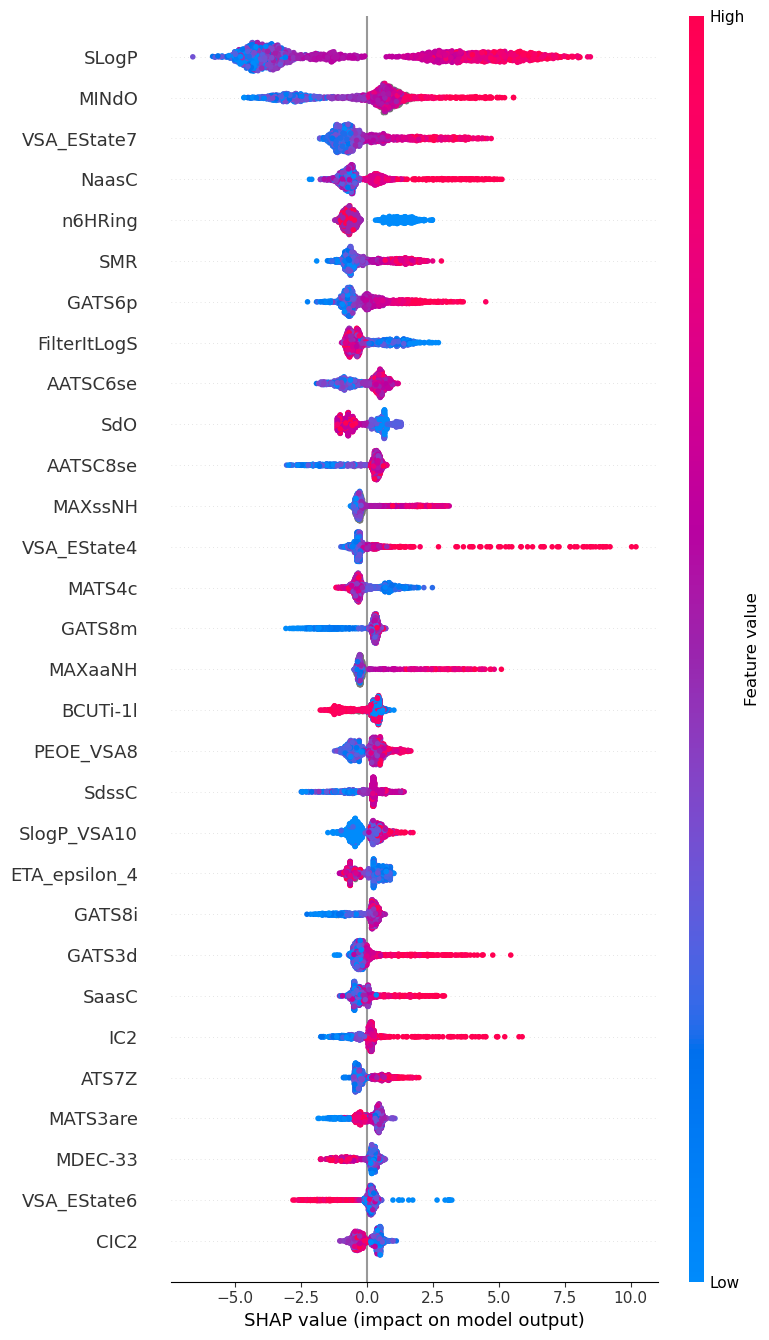

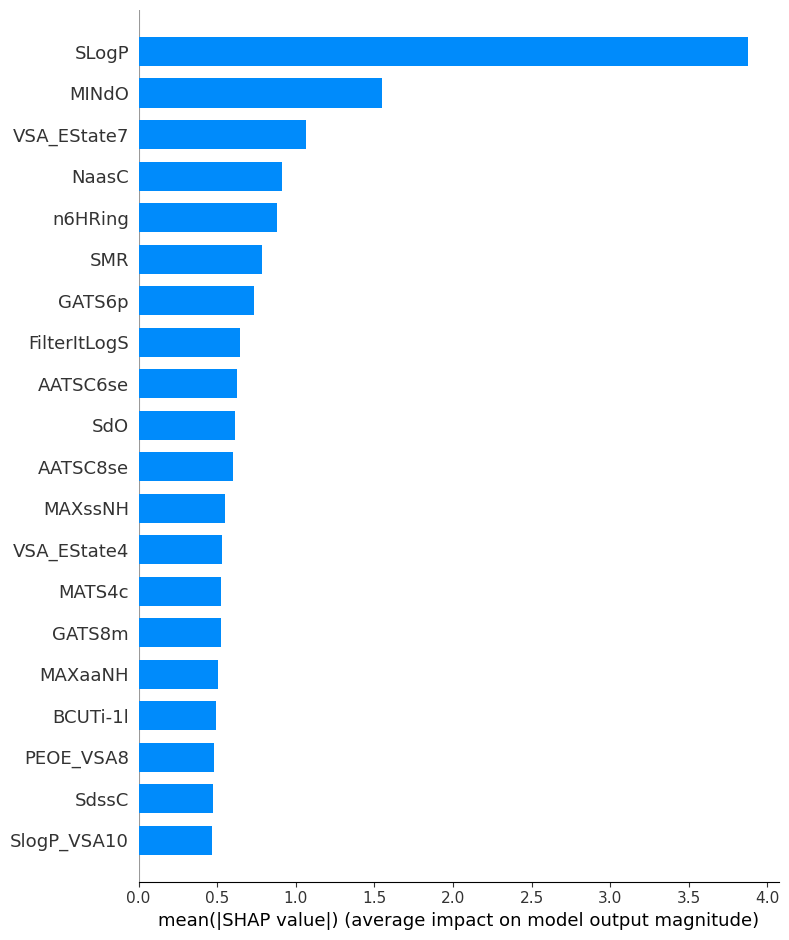

In [25]:
# 10. SHAP 시각화
explainer_final = shap.Explainer(final_model)
shap_values_final = explainer_final(X_top_scaled)

# Summary plot (전체 중요도)
shap.summary_plot(shap_values_final, features=X_top, feature_names=top_200_features, max_display=30)

# Bar plot (중요도 바 차트)
shap.summary_plot(shap_values_final, features=X_top, feature_names=top_200_features, plot_type="bar")

In [26]:
# 11. Prepare test data
test = pd.read_csv("data/test.csv")
test = test[['ID', 'Canonical_Smiles']]
test['mol'] = test['Canonical_Smiles'].apply(Chem.MolFromSmiles)
test = test[test['mol'].notnull()].reset_index(drop=True)

desc_test = calc.pandas(test['mol']).replace([np.inf, -np.inf], np.nan)
valid_features = [f for f in top_200_features if f in desc_test.columns]
desc_test = desc_test[valid_features]
desc_test = desc_test.apply(pd.to_numeric, errors='coerce')

# Fill NaN with train mean
train_mean = X[valid_features].mean()
desc_test = desc_test.fillna(train_mean)

# Reorder columns to match training
desc_test = desc_test[valid_features]

# Scale test features
X_test_scaled = scaler.transform(desc_test)

# Predict test set
test_pred = final_model.predict(X_test_scaled)

100%|██████████| 100/100 [00:02<00:00, 36.52it/s]


In [27]:
# 12. Save submission
submit = pd.read_csv("data/sample_submission.csv")
submit['Inhibition'] = test_pred
submit.to_csv("enhance_v4.1_submit.csv", index=False)
print("Submission saved to 'enhance_v4.1_submit.csv'")

Submission saved to 'enhance_v4.1_submit.csv'
